In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
train_image_dir="/Users/withmocha/Desktop/DATA/Capston Design(2024)/deep voice data/image/small/train/"
test_image_dir="/Users/withmocha/Desktop/DATA/Capston Design(2024)/deep voice data/image/small/test/"

In [3]:
train_datagen = ImageDataGenerator( 
    rescale=1./255,
    preprocessing_function=preprocess_input,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.inception_v3 import preprocess_input  
def get_dataset(directory, batch_size):
    dataset = image_dataset_from_directory(
        directory,
        shuffle=True,
        batch_size=batch_size,
        image_size=(299, 299),
        label_mode='binary',
    )
    class_names = dataset.class_names  
    dataset = dataset.map(lambda x, y: (preprocess_input(x), y))
    return dataset, class_names  

In [5]:
train_dataset, train_class_names = get_dataset(train_image_dir, 100)
val_dataset, val_class_names = get_dataset(test_image_dir, 100)

Found 2832 files belonging to 2 classes.
Found 940 files belonging to 2 classes.


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)


In [7]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)



In [8]:
for layer in base_model.layers[-50:]:
    layer.trainable = True


In [9]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr) 
    else:
        return float(lr * tf.math.exp(-0.1))  

lr_scheduler = LearningRateScheduler(scheduler)


In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)


In [11]:
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[early_stopping, lr_scheduler, reduce_lr],
)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1013s 35s/step - accuracy: 0.8536 - loss: 0.9335 - val_accuracy: 0.5319 - val_loss: 2562.7522 - learning_rate: 0.0020
Epoch 2/10
 8/29 ━━━━━━━━━━━━━━━━━━━━ 11:18 32s/step - accuracy: 0.9919 - loss: 0.0437

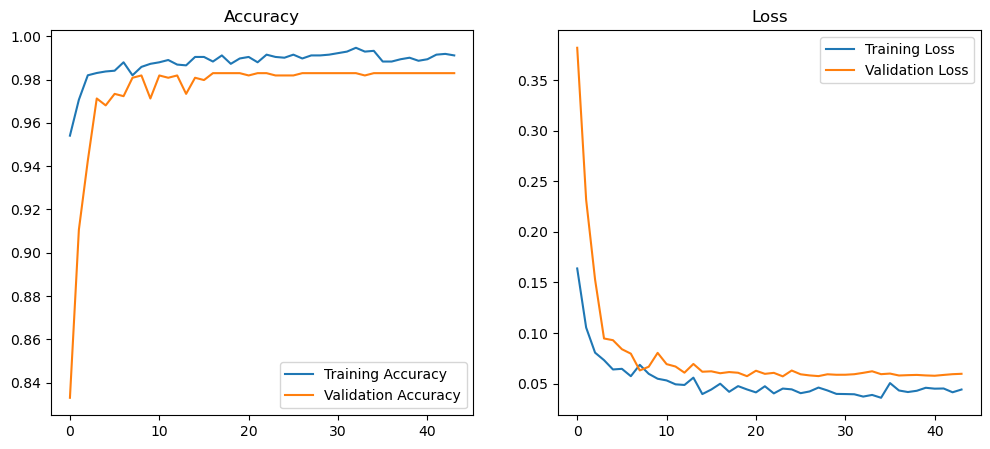

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, f1_score, accuracy_score

# 검증 데이터셋에 대한 예측 확률을 얻기
val_predictions = model.predict(val_dataset)
val_labels = np.concatenate([y for x, y in val_dataset], axis=0)

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(val_labels, val_predictions)

# Youden의 J지수 계산
J = tpr - fpr
idx = np.argmax(J)
best_thresh_youden = thresholds[idx]
print(f"Youden의 J지수를 최대화하는 임계값: {best_thresh_youden}")

# 다양한 임계값에 대한 F1 score 계산
f1_scores = [f1_score(val_labels, val_predictions > t) for t in thresholds]
best_thresh_f1 = thresholds[np.argmax(f1_scores)]
print(f"F1 score를 최대화하는 임계값: {best_thresh_f1}")

# 최적의 임계값을 사용하여 이진 분류 수행
optimized_pred_youden = (val_predictions > best_thresh_youden).astype(int)
optimized_pred_f1 = (val_predictions > best_thresh_f1).astype(int)

# 이진 분류 결과의 정확도 평가
accuracy_youden = accuracy_score(val_labels, optimized_pred_youden)
accuracy_f1 = accuracy_score(val_labels, optimized_pred_f1)

print(f"Youden의 J지수를 사용한 최적의 임계값에 대한 정확도: {accuracy_youden}")
print(f"F1 score를 사용한 최적의 임계값에 대한 정확도: {accuracy_f1}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 742ms/step


2024-05-16 08:04:08.399550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Youden의 J지수를 최대화하는 임계값: 0.9962825179100037
F1 score를 최대화하는 임계값: 3.1598696637047397e-07
Youden의 J지수를 사용한 최적의 임계값에 대한 정확도: 0.5138297872340426
F1 score를 사용한 최적의 임계값에 대한 정확도: 0.5329787234042553


In [ ]:
import numpy as np

class_labels = val_class_names

true_classes = []
for _, labels in val_dataset.take(-1): 
    true_classes.extend(labels.numpy())
true_classes = np.array(true_classes)


predictions = model.predict(val_dataset)
predicted_classes = np.where(predictions > best_thresh_f1, 1, 0)



2024-05-16 07:58:57.347614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 804ms/step


In [ ]:
true_classes

array([[1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],

In [ ]:
predicted_classes

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

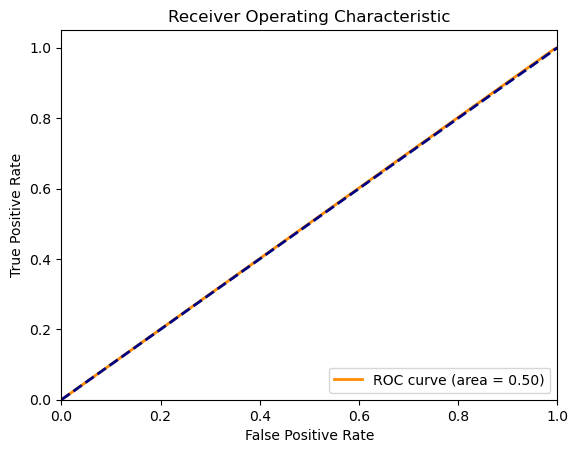

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import numpy as np


fpr, tpr, _ = roc_curve(true_classes, predicted_classes)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

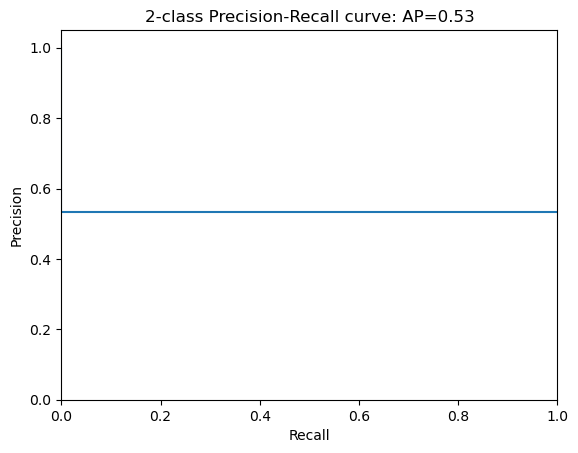

In [ ]:
precision, recall, _ = precision_recall_curve(true_classes, predicted_classes)
average_precision = average_precision_score(true_classes, predicted_classes)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

Confusion Matrix:


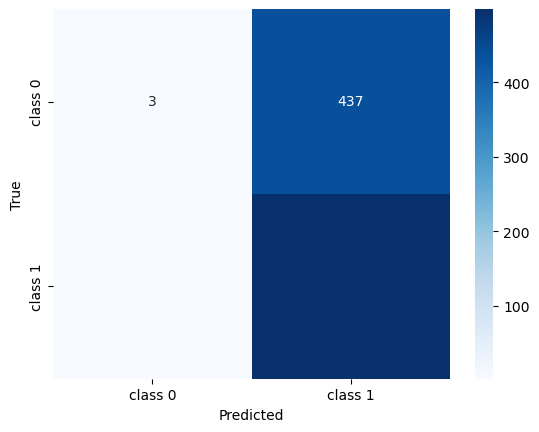

Classification Report:
              precision    recall  f1-score   support

     class 0       0.60      0.01      0.01       440
     class 1       0.53      1.00      0.69       500

    accuracy                           0.53       940
   macro avg       0.57      0.50      0.35       940
weighted avg       0.56      0.53      0.38       940



In [ ]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('Classification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [ ]:
with open("V3 confusion matrix.txt", "w") as text_file:
    print(confusion_matrix(true_classes, predicted_classes), file=text_file)

In [ ]:
with open("V3 classification report output.txt", "w") as text_file:
    print(classification_report(true_classes, predicted_classes,digits=4), file=text_file)